In [3]:
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import statsmodels.api as sm

## Load data

In [4]:
# treatment group post-exp
T_e2e_post = pd.read_csv('order_e2e_post_500.csv')  

In [5]:
T_other_comp0 =  pd.read_csv('control_demand_vlt.csv') # load the ave-demand and ave-vlt for all sku-dc pairs 

In [6]:
len(T_other_comp0)

55333

In [7]:
len(T_e2e_post)

500

In [8]:
N_e2e = len(T_e2e_post)
N_other = len(T_other_comp0)

In [9]:
vlt_e2e = []
for i in range(N_e2e):
#     if type(T_e2e_post.vlt[i]) == int:
#         vlt_e2e.append(T_e2e_post.vlt[i])
#     else:
    vlt_e2e.append(int(T_e2e_post.vlt.values[i].split(' ')[0]))

In [10]:
T_e2e_post['vlt_num'] = vlt_e2e

In [11]:
test = T_e2e_post[['ave_demand', 'vlt_num']]
test['e2e'] = np.ones(N_e2e)
control = T_other_comp0[['ave_demand', 'vlt_num']]
control['e2e'] = np.zeros(N_other)

<ipython-input-11-48dc572a4f5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['e2e'] = np.ones(N_e2e)
<ipython-input-11-48dc572a4f5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['e2e'] = np.zeros(N_other)


In [12]:
origin_data = pd.concat([test, control], ignore_index=True)

In [13]:
#calculate original propensity score:
propensity = LogisticRegression()
propensity = propensity.fit(origin_data[['ave_demand', 'vlt_num']], origin_data.e2e)
pscore = propensity.predict_proba(origin_data[['ave_demand', 'vlt_num']])[:,1] # The predicted propensities by the model

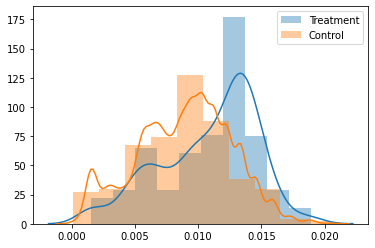

In [14]:
sns.distplot(pscore[:N_e2e], hist = True, bins = 10, label = 'Treatment')
sns.distplot(pscore[N_e2e:], hist = True, bins = 10, label = 'Control')
plt.legend()
#plt.xlim(left = 0.003, right = 0.017) 
# plt.show()
plt.savefig('prop_score_prep.pdf')

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def get_matching_pairs(treated_df, non_treated_df):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values
#     if scaler == True:
#         scaler = StandardScaler()
#     if scaler:
#         scaler.fit(treated_x)
#         treated_x = scaler.transform(treated_x)
#         non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
#     print(indices.reshape(-1,3)[:,2])
    indices = indices.reshape(indices.shape[0])
    return indices

matched_idx = get_matching_pairs(test, control)

T_matched_comp = T_other_comp0.iloc[matched_idx]

# plt.hist(T_matched_comp.vlt_num, bins = 6)
# plt.show()

In [16]:
control1 = control.iloc[matched_idx]
prop_data = pd.concat([test, control1], ignore_index=True)
pscore = propensity.predict_proba(prop_data[['ave_demand', 'vlt_num']])[:,1] # The predicted propensities by the model

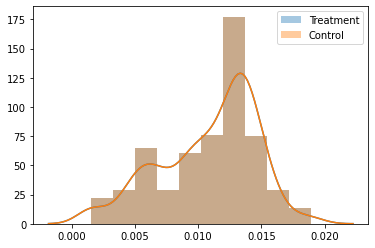

In [17]:
sns.distplot(pscore[:N_e2e], hist = True, bins = 10, label = 'Treatment')
sns.distplot(pscore[N_e2e:], hist = True, bins = 10, label = 'Control')
plt.legend()
plt.savefig('prop_score2.pdf')
plt.show()